In [11]:
# Install necessary libraries
!pip install xgboost ta tensorflow


Raw data shape: (1301, 8)
Raw columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Unnamed: 7']
Raw data (first 5 rows):
                   Date      Open      High       Low     Close Adj Close  \
0  2025-02-12 00:00:00   23050.8   23144.7  22798.35  23045.25  23045.25   
1  2025-02-11 00:00:00  23383.55  23390.05  22986.65   23071.8   23071.8   
2  2025-02-10 00:00:00   23543.8   23568.6   23316.3   23381.6   23381.6   
3  2025-02-07 00:00:00   23649.5   23694.5   23443.2  23559.95  23559.95   
4  2025-02-06 00:00:00  23761.95  23773.55  23556.25  23603.35  23603.35   

   Volume Unnamed: 7  
0       -        NaN  
1  268000        NaN  
2  234200        NaN  
3  368100        NaN  
4  307000        NaN  
Dropped 'Unnamed: 7' column

Shape after removing empty rows: (1301, 7)

Invalid dates count: 28

NaN counts after numeric conversion:
 Open         72
High         26
Low          26
Close        26
Adj Close    26
Volume       41
dtype: int64

Final cleaned sh

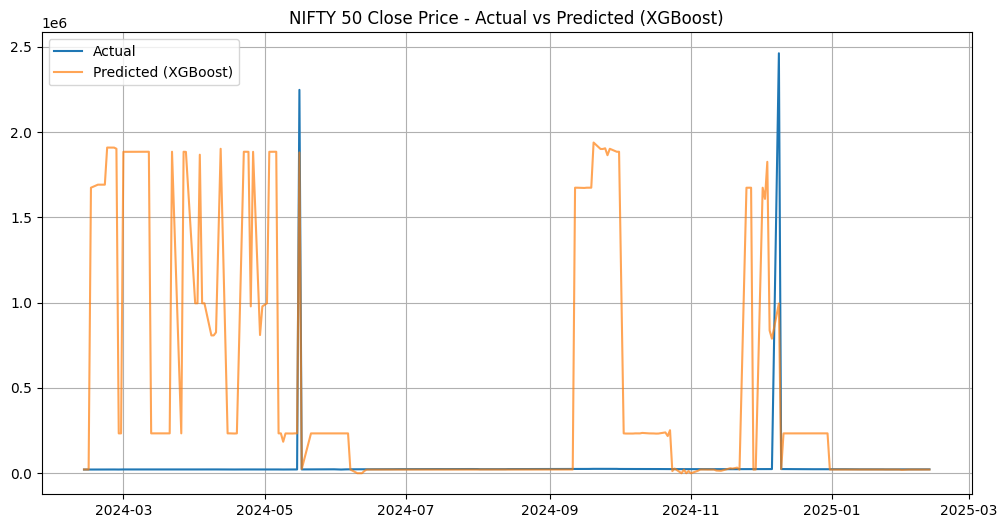

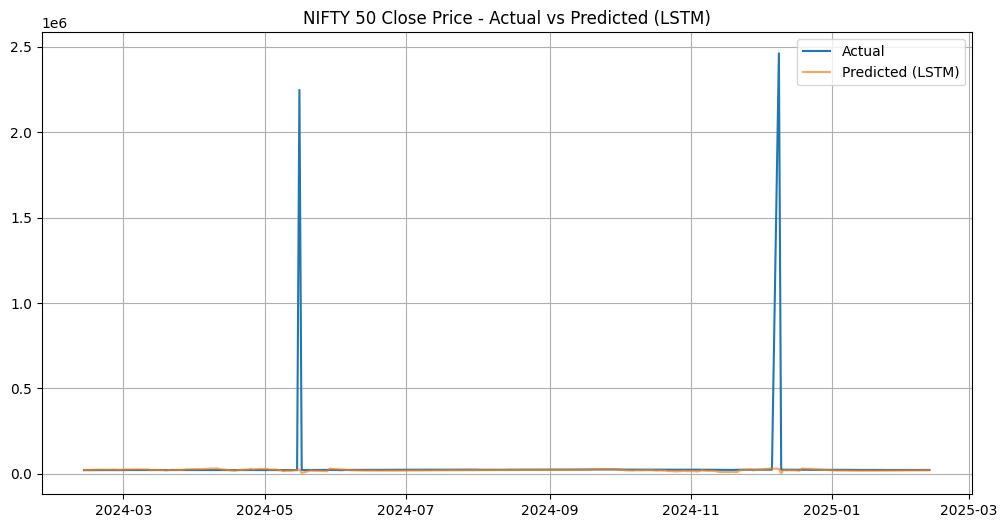


Feature Importance (XGBoost):
Volatility    0.222985
Lag1_Close    0.211635
RSI           0.179213
Close         0.179017
Lag2_Close    0.146045
MA7           0.044901
Signal        0.016204
dtype: float32


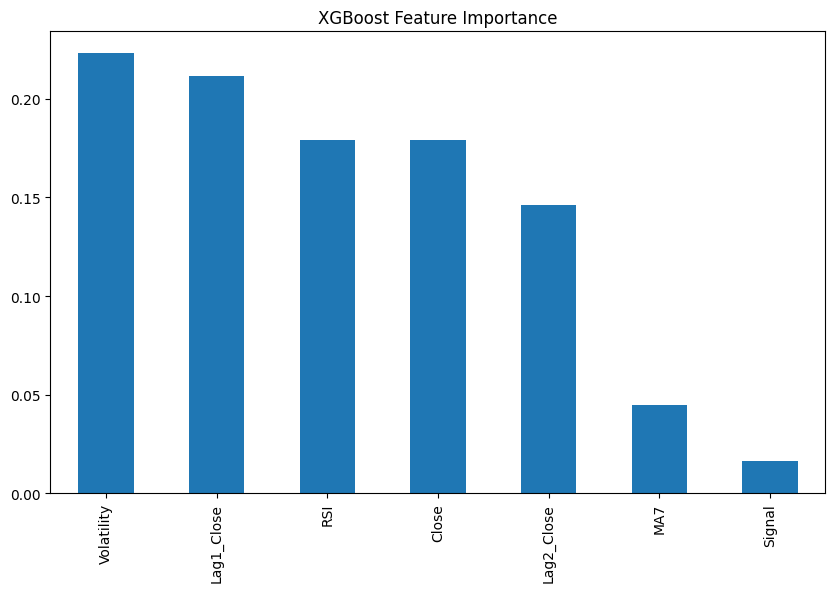

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import ta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

# Load data
file_name = "NIFTY 50 - Yahoo Finance.xlsx"  # Replace if needed
df_raw = pd.read_excel(file_name)

# Debug: Inspect raw data
print("Raw data shape:", df_raw.shape)
print("Raw columns:", df_raw.columns.tolist())
print("Raw data (first 5 rows):\n", df_raw.head())

# Clean column names and drop useless columns
df_raw.columns = [str(col).strip() for col in df_raw.columns]
if 'Unnamed: 7' in df_raw.columns:
    df_raw = df_raw.drop(columns=['Unnamed: 7'])
    print("Dropped 'Unnamed: 7' column")

# Check for 'Date' column
if 'Date' not in df_raw.columns:
    for col in df_raw.columns:
        if 'date' in str(col).lower() or col.startswith('Unnamed'):
            print(f"Renaming column '{col}' to 'Date'")
            df_raw.rename(columns={col: 'Date'}, inplace=True)
            break
    else:
        raise ValueError("No 'Date' column found: " + str(df_raw.columns.tolist()))

# Remove fully empty rows
df_raw = df_raw.dropna(how='all')
print("\nShape after removing empty rows:", df_raw.shape)

# Convert 'Date' column
def convert_date(date):
    try:
        if isinstance(date, (int, float)) and 40000 < date < 50000:
            return pd.to_datetime(date, unit='D', origin='1899-12-30')
        date_str = str(date).strip()
        if date_str == '' or date_str.lower() == 'nan':
            return pd.NaT
        date_str = date_str.replace('  ', ' ').replace('O t', 'Oct')
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

df_raw['Date'] = df_raw['Date'].apply(convert_date)
print("\nInvalid dates count:", df_raw['Date'].isna().sum())

# Drop rows with invalid dates
df_raw = df_raw.dropna(subset=['Date'])

# Clean numeric columns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_cols:
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].astype(str).str.replace(' ', '', regex=False).replace('-', np.nan)
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found")

# Debug: Check NaNs
print("\nNaN counts after numeric conversion:\n", df_raw[numeric_cols].isna().sum())

# Filter rows with valid 'Close' and drop duplicates
df = df_raw[df_raw['Close'].notna()].drop_duplicates(subset=['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
print("\nFinal cleaned shape:", df.shape)
print("Final data (first 5 rows):\n", df.head())
if df.empty:
    raise ValueError("Cleaned dataset is empty.")

# Feature Engineering
df['Target'] = df['Close'].shift(-1)
df['Return'] = df['Close'].pct_change()
df['Lag1_Close'] = df['Close'].shift(1)
df['Lag2_Close'] = df['Close'].shift(2)
df['MA7'] = df['Close'].rolling(window=7).mean()
df['Volatility'] = df['Return'].rolling(window=7).std()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['Signal'] = ta.trend.MACD(df['Close']).macd_signal()

# Handle Volume
df['Volume'] = df['Volume'].fillna(method='ffill').fillna(df['Volume'].median())

# Debug: Check NaNs
print("\nNaN counts after feature engineering:\n", df.isna().sum())

# Impute NaNs
df = df.fillna(method='ffill').fillna(method='bfill')

# Feature Set (refined based on importance)
features = ['Close', 'Lag1_Close', 'Lag2_Close', 'MA7', 'Volatility', 'RSI', 'Signal']
X = df[features]
y = df['Target']

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Debug: Check scaled data
print("\nX_scaled shape:", X_scaled.shape)
print("y_scaled shape:", y_scaled.shape)
print("NaNs in X_scaled:", np.isnan(X_scaled).sum())
print("NaNs in y_scaled:", np.isnan(y_scaled).sum())

# Train-Test Split
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Debug: Check split
print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
if len(X_train) == 0 or len(y_train) == 0:
    raise ValueError("Training data is empty.")

# XGBoost with expanded tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 5, 9]
}
model = XGBRegressor(random_state=42)
n_splits = min(3, len(X_train) // 2)
if n_splits < 2:
    raise ValueError(f"Too few samples ({len(X_train)}) for cross-validation.")
grid_search = GridSearchCV(model, param_grid, cv=TimeSeriesSplit(n_splits=n_splits),
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict and Evaluate XGBoost
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
mse = mean_squared_error(y_test_unscaled, y_pred)
r2 = r2_score(y_test_unscaled, y_pred)
print(f"XGBoost - MSE: {mse:.2f}, R²: {r2:.4f}")

# LSTM Model
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_train, y_test

model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(1, X_scaled.shape[1])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, verbose=0,
               callbacks=[EarlyStopping(patience=10)])

y_pred_lstm_scaled = model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled).ravel()
y_test_lstm_unscaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1)).ravel()
mse_lstm = mean_squared_error(y_test_lstm_unscaled, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm_unscaled, y_pred_lstm)
print(f"LSTM - MSE: {mse_lstm:.2f}, R²: {r2_lstm:.4f}")

# Plot Actual vs Predicted (XGBoost)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], y_test_unscaled, label='Actual')
plt.plot(df.index[split_index:], y_pred, label='Predicted (XGBoost)', alpha=0.7)
plt.title("NIFTY 50 Close Price - Actual vs Predicted (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Actual vs Predicted (LSTM)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], y_test_lstm_unscaled, label='Actual')
plt.plot(df.index[split_index:], y_pred_lstm, label='Predicted (LSTM)', alpha=0.7)
plt.title("NIFTY 50 Close Price - Actual vs Predicted (LSTM)")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance (XGBoost)
importances = best_model.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importance (XGBoost):")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10,6))
feature_importance.plot(kind='bar')
plt.title("XGBoost Feature Importance")
plt.show()

Raw data shape: (1301, 8)
Raw columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Unnamed: 7']
Raw data (first 5 rows):
                   Date      Open      High       Low     Close Adj Close  \
0  2025-02-12 00:00:00   23050.8   23144.7  22798.35  23045.25  23045.25   
1  2025-02-11 00:00:00  23383.55  23390.05  22986.65   23071.8   23071.8   
2  2025-02-10 00:00:00   23543.8   23568.6   23316.3   23381.6   23381.6   
3  2025-02-07 00:00:00   23649.5   23694.5   23443.2  23559.95  23559.95   
4  2025-02-06 00:00:00  23761.95  23773.55  23556.25  23603.35  23603.35   

   Volume Unnamed: 7  
0       -        NaN  
1  268000        NaN  
2  234200        NaN  
3  368100        NaN  
4  307000        NaN  
Dropped 'Unnamed: 7' column

Shape after removing empty rows: (1301, 7)

Invalid dates count: 28

Date range: 2020-02-12 00:00:00 to 2025-02-12 00:00:00

NaN counts after numeric conversion:
 Open         46
High          0
Low           0
Close         0
Adj Cl

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
LSTM - MSE: 79.093102, R²: -0.0061


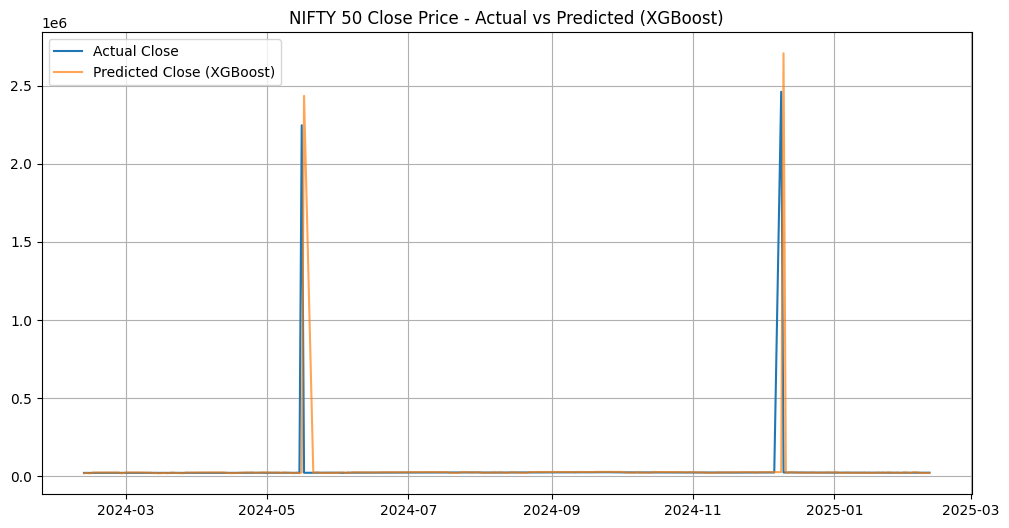

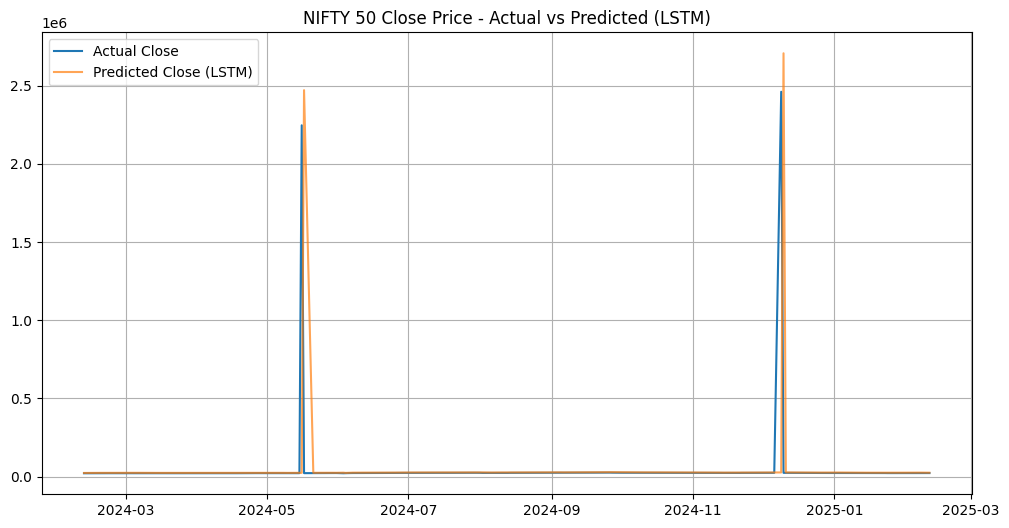

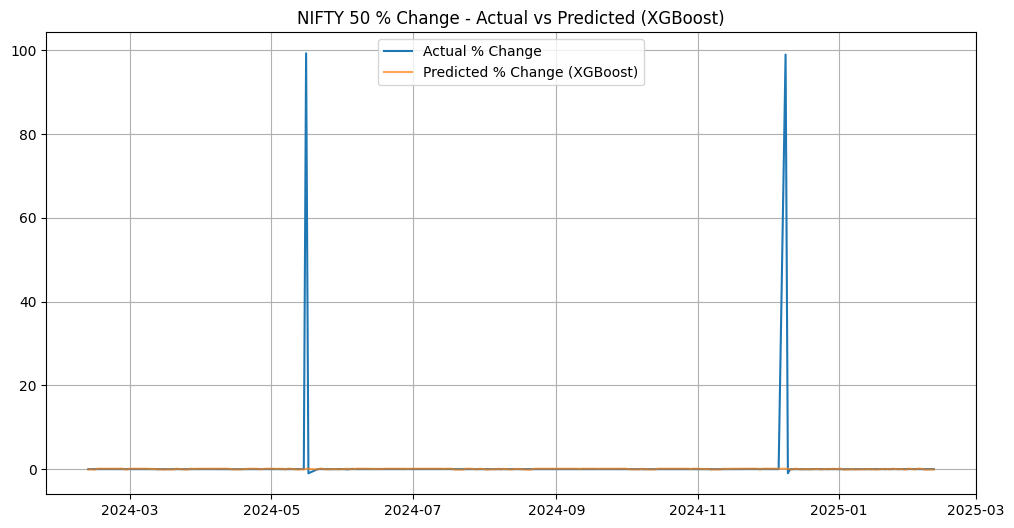

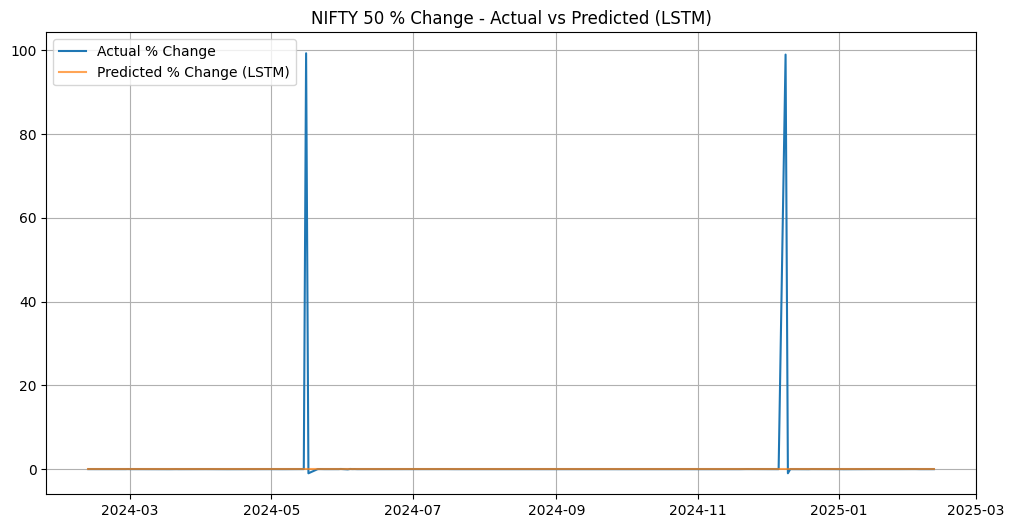


Feature Importance (XGBoost):
MA7_Diff      0.178682
Close_Pct     0.174140
Lag2_Close    0.152926
Lag1_Close    0.144121
Volatility    0.134868
Stochastic    0.116920
RSI           0.098342
dtype: float32


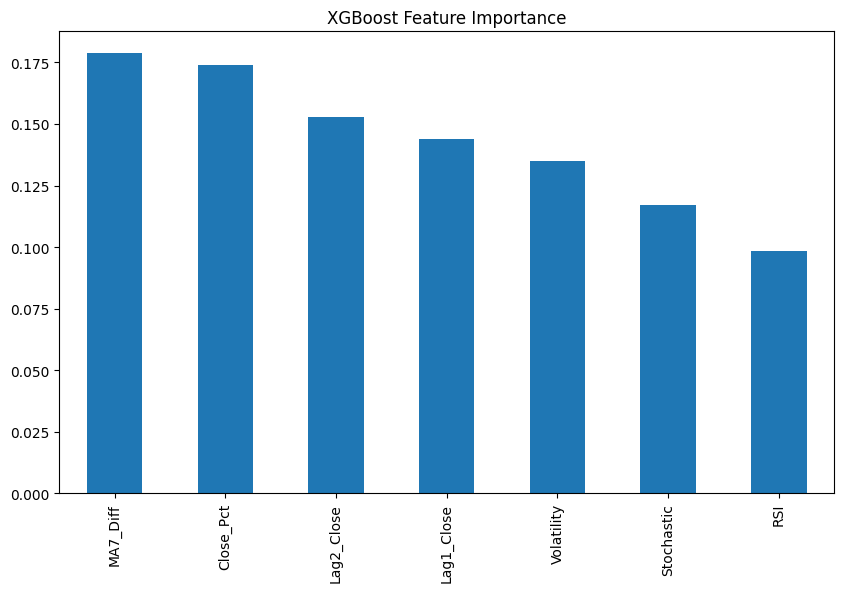

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import ta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

# Load data
file_name = "NIFTY 50 - Yahoo Finance.xlsx"
df_raw = pd.read_excel(file_name)

# Debug: Inspect raw data
print("Raw data shape:", df_raw.shape)
print("Raw columns:", df_raw.columns.tolist())
print("Raw data (first 5 rows):\n", df_raw.head())

# Clean column names and drop useless columns
df_raw.columns = [str(col).strip() for col in df_raw.columns]
if 'Unnamed: 7' in df_raw.columns:
    df_raw = df_raw.drop(columns=['Unnamed: 7'])
    print("Dropped 'Unnamed: 7' column")

# Check for 'Date' column
if 'Date' not in df_raw.columns:
    for col in df_raw.columns:
        if 'date' in str(col).lower() or col.startswith('Unnamed'):
            print(f"Renaming column '{col}' to 'Date'")
            df_raw.rename(columns={col: 'Date'}, inplace=True)
            break
    else:
        raise ValueError("No 'Date' column found: " + str(df_raw.columns.tolist()))

# Remove empty rows
df_raw = df_raw.dropna(how='all')
print("\nShape after removing empty rows:", df_raw.shape)

# Convert 'Date' column
def convert_date(date):
    try:
        if isinstance(date, (int, float)) and 40000 < date < 50000:
            return pd.to_datetime(date, unit='D', origin='1899-12-30')
        date_str = str(date).strip()
        if date_str == '' or date_str.lower() == 'nan':
            return pd.NaT
        date_str = date_str.replace('  ', ' ').replace('O t', 'Oct')
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

df_raw['Date'] = df_raw['Date'].apply(convert_date)
print("\nInvalid dates count:", df_raw['Date'].isna().sum())

# Drop invalid dates
df_raw = df_raw.dropna(subset=['Date'])

# Filter out future dates
current_date = pd.to_datetime('2025-04-16')
df_raw = df_raw[df_raw['Date'] <= current_date]
print("\nDate range:", df_raw['Date'].min(), "to", df_raw['Date'].max())

# Clean numeric columns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_cols:
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].astype(str).str.replace(' ', '', regex=False).replace('-', np.nan)
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found")

# Debug: Check NaNs
print("\nNaN counts after numeric conversion:\n", df_raw[numeric_cols].isna().sum())

# Filter valid 'Close' and drop duplicates
df = df_raw[df_raw['Close'].notna()].drop_duplicates(subset=['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
print("\nFinal cleaned shape:", df.shape)
print("Final data (first 5 rows):\n", df.head())
if df.empty:
    raise ValueError("Cleaned dataset is empty.")

# Feature Engineering
df['Target'] = df['Close'].pct_change().shift(-1)
df['Close_Pct'] = df['Close'].pct_change()
df['Lag1_Close'] = df['Close'].pct_change().shift(1)
df['Lag2_Close'] = df['Close'].pct_change().shift(2)
df['MA7_Diff'] = (df['Close'].rolling(window=7).mean() - df['Close']) / df['Close']
df['Volatility'] = df['Close'].pct_change().rolling(window=7).std()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['Stochastic'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close']).stoch()

# Handle Volume
df['Volume'] = df['Volume'].fillna(method='ffill').fillna(df['Volume'].median())

# Debug: Check NaNs
print("\nNaN counts after feature engineering:\n", df.isna().sum())

# Drop rows with NaN Target
df = df.dropna(subset=['Target'])

# Impute remaining NaNs
df = df.fillna(method='ffill').fillna(method='bfill')

# Feature Set
features = ['Close_Pct', 'Lag1_Close', 'Lag2_Close', 'MA7_Diff', 'Volatility', 'RSI', 'Stochastic']
X = df[features]
y = df['Target']

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Debug: Check scaled data
print("\nX_scaled shape:", X_scaled.shape)
print("y_scaled shape:", y_scaled.shape)
print("NaNs in X_scaled:", np.isnan(X_scaled).sum())
print("NaNs in y_scaled:", np.isnan(y_scaled).sum())
print("y_scaled range:", y_scaled.min(), y_scaled.max())

# Train-Test Split
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Debug: Check split
print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
if len(X_train) == 0 or len(y_train) == 0:
    raise ValueError("Training data is empty.")

# XGBoost
param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}
model = XGBRegressor(random_state=42)
n_splits = min(3, len(X_train) // 2)
if n_splits < 2:
    raise ValueError(f"Too few samples ({len(X_train)}) for cross-validation.")
grid_search = GridSearchCV(model, param_grid, cv=TimeSeriesSplit(n_splits=n_splits),
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict and Evaluate XGBoost
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_pred = np.clip(y_pred, -0.1, 0.1)  # Prevent extreme predictions
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
mse = mean_squared_error(y_test_unscaled, y_pred)
r2 = r2_score(y_test_unscaled, y_pred)
print(f"XGBoost - MSE: {mse:.6f}, R²: {r2:.4f}")

# Convert % change to Close prices
close_test = df['Close'].iloc[split_index:].values
print("close_test shape:", close_test.shape)
print("y_pred shape:", y_pred.shape)
close_pred = close_test * (1 + y_pred)
close_actual = close_test * (1 + y_test_unscaled)

# LSTM Model
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_train, y_test

model_lstm = Sequential()
model_lstm.add(LSTM(150, return_sequences=True, input_shape=(1, X_scaled.shape[1])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(150, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(150))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=RMSprop(), loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=200, batch_size=8, verbose=0,
               callbacks=[EarlyStopping(patience=15)])

y_pred_lstm_scaled = model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled).ravel()
y_pred_lstm = np.clip(y_pred_lstm, -0.1, 0.1)
y_test_lstm_unscaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1)).ravel()
mse_lstm = mean_squared_error(y_test_lstm_unscaled, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm_unscaled, y_pred_lstm)
print(f"LSTM - MSE: {mse_lstm:.6f}, R²: {r2_lstm:.4f}")

# Convert LSTM % change to Close
close_pred_lstm = close_test * (1 + y_pred_lstm)

# Plot Actual vs Predicted Close (XGBoost)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], close_actual, label='Actual Close')
plt.plot(df.index[split_index:], close_pred, label='Predicted Close (XGBoost)', alpha=0.7)
plt.title("NIFTY 50 Close Price - Actual vs Predicted (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Actual vs Predicted Close (LSTM)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], close_actual, label='Actual Close')
plt.plot(df.index[split_index:], close_pred_lstm, label='Predicted Close (LSTM)', alpha=0.7)
plt.title("NIFTY 50 Close Price - Actual vs Predicted (LSTM)")
plt.legend()
plt.grid(True)
plt.show()

# Plot % Change Predictions (XGBoost)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], y_test_unscaled, label='Actual % Change')
plt.plot(df.index[split_index:], y_pred, label='Predicted % Change (XGBoost)', alpha=0.7)
plt.title("NIFTY 50 % Change - Actual vs Predicted (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Plot % Change Predictions (LSTM)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], y_test_lstm_unscaled, label='Actual % Change')
plt.plot(df.index[split_index:], y_pred_lstm, label='Predicted % Change (LSTM)', alpha=0.7)
plt.title("NIFTY 50 % Change - Actual vs Predicted (LSTM)")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance (XGBoost)
importances = best_model.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importance (XGBoost):")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10,6))
feature_importance.plot(kind='bar')
plt.title("XGBoost Feature Importance")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import ta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

# Load data
file_name = "NIFTY 50 - Yahoo Finance.xlsx"
df_raw = pd.read_excel(file_name)

# Debug: Inspect raw data
print("Raw data shape:", df_raw.shape)
print("Raw columns:", df_raw.columns.tolist())
print("Raw data (first 5 rows):\n", df_raw.head())

# Clean column names and drop useless columns
df_raw.columns = [str(col).strip() for col in df_raw.columns]
if 'Unnamed: 7' in df_raw.columns:
    df_raw = df_raw.drop(columns=['Unnamed: 7'])
    print("Dropped 'Unnamed: 7' column")

# Check for 'Date' column
if 'Date' not in df_raw.columns:
    for col in df_raw.columns:
        if 'date' in str(col).lower() or col.startswith('Unnamed'):
            print(f"Renaming column '{col}' to 'Date'")
            df_raw.rename(columns={col: 'Date'}, inplace=True)
            break
    else:
        raise ValueError("No 'Date' column found: " + str(df_raw.columns.tolist()))

# Remove empty rows
df_raw = df_raw.dropna(how='all')
print("\nShape after removing empty rows:", df_raw.shape)

# Convert 'Date' column
def convert_date(date):
    try:
        if isinstance(date, (int, float)) and 40000 < date < 50000:
            return pd.to_datetime(date, unit='D', origin='1899-12-30')
        date_str = str(date).strip()
        if date_str == '' or date_str.lower() == 'nan':
            return pd.NaT
        date_str = date_str.replace('  ', ' ').replace('O t', 'Oct')
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

df_raw['Date'] = df_raw['Date'].apply(convert_date)
print("\nInvalid dates count:", df_raw['Date'].isna().sum())

# Drop invalid dates
df_raw = df_raw.dropna(subset=['Date'])

# Filter out future dates
current_date = pd.to_datetime('2025-04-16')
df_raw = df_raw[df_raw['Date'] <= current_date]
print("\nDate range:", df_raw['Date'].min(), "to", df_raw['Date'].max())

# Clean numeric columns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_cols:
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].astype(str).str.replace(' ', '', regex=False).replace('-', np.nan)
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found")

# Debug: Check NaNs
print("\nNaN counts after numeric conversion:\n", df_raw[numeric_cols].isna().sum())

# Filter valid 'Close' and drop duplicates
df = df_raw[df_raw['Close'].notna()].drop_duplicates(subset=['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
print("\nFinal cleaned shape:", df.shape)
print("Final data (first 5 rows):\n", df.head())
if df.empty:
    raise ValueError("Cleaned dataset is empty.")

# Feature Engineering
df['Target'] = df['Close'].pct_change().shift(-1)
df['Target_Dir'] = (df['Target'] > 0).astype(int)  # 1 for up, 0 for down
df['Close_Pct'] = df['Close'].pct_change()
df['Lag1_Close'] = df['Close'].pct_change().shift(1)
df['MA5_Diff'] = (df['Close'].rolling(window=5).mean() - df['Close']) / df['Close']
df['Volatility'] = df['Close'].pct_change().rolling(window=7).std()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['Stochastic'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close']).stoch()
df['ADX'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'], window=14).adx()

# Handle Volume
df['Volume'] = df['Volume'].fillna(method='ffill').fillna(df['Volume'].median())

# Debug: Check NaNs
print("\nNaN counts after feature engineering:\n", df.isna().sum())

# Drop rows with NaN Target
df = df.dropna(subset=['Target'])

# Impute remaining NaNs
df = df.fillna(method='ffill').fillna(method='bfill')

# Feature Set
features = ['Close_Pct', 'Lag1_Close', 'MA5_Diff', 'Volatility', 'RSI', 'Stochastic', 'ADX']
X = df[features]
y = df['Target']
y_dir = df['Target_Dir']

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Debug: Check scaled data
print("\nX_scaled shape:", X_scaled.shape)
print("y_scaled shape:", y_scaled.shape)
print("NaNs in X_scaled:", np.isnan(X_scaled).sum())
print("NaNs in y_scaled:", np.isnan(y_scaled).sum())
print("y_scaled range:", y_scaled.min(), y_scaled.max())
print("y_unscaled sample:", y[:5].values)

# Train-Test Split
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]
y_dir_train, y_dir_test = y_dir.iloc[:split_index], y_dir.iloc[split_index:]

# Debug: Check split
print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
if len(X_train) == 0 or len(y_train) == 0:
    raise ValueError("Training data is empty.")

# XGBoost for Regression
param_grid = {
    'n_estimators': [1000, 2000, 3000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}
model = XGBRegressor(random_state=42)
n_splits = min(3, len(X_train) // 2)
if n_splits < 2:
    raise ValueError(f"Too few samples ({len(X_train)}) for cross-validation.")
grid_search = GridSearchCV(model, param_grid, cv=TimeSeriesSplit(n_splits=n_splits),
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict and Evaluate XGBoost
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_pred = np.clip(y_pred, -0.05, 0.05)
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
mse = mean_squared_error(y_test_unscaled, y_pred)
r2 = r2_score(y_test_unscaled, y_pred)
y_pred_dir = (y_pred > 0).astype(int)
dir_accuracy = accuracy_score(y_dir_test, y_pred_dir)
print(f"XGBoost - MSE: {mse:.6f}, R²: {r2:.4f}, Directional Accuracy: {dir_accuracy:.4f}")
print("Sample predictions:", y_pred[:5])
print("Sample actual:", y_test_unscaled[:5])

# Convert % change to Close prices
close_test = df['Close'].iloc[split_index:].values
close_pred = close_test * (1 + y_pred)
close_actual = close_test * (1 + y_test_unscaled)

# LSTM Model
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_train, y_test

model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(200, return_sequences=True), input_shape=(1, X_scaled.shape[1])))
model_lstm.add(Dropout(0.3))
model_lstm.add(Bidirectional(LSTM(200, return_sequences=True)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Bidirectional(LSTM(200)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=300, batch_size=4, verbose=0,
               callbacks=[EarlyStopping(patience=20)])

# Precompile prediction to avoid retracing
@tf.function(reduce_retracing=True)
def predict_lstm(model, x):
    return model(x, training=False)

y_pred_lstm_scaled = predict_lstm(model_lstm, X_test_lstm).numpy()
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled).ravel()
y_pred_lstm = np.clip(y_pred_lstm, -0.05, 0.05)
y_test_lstm_unscaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1)).ravel()
mse_lstm = mean_squared_error(y_test_lstm_unscaled, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm_unscaled, y_pred_lstm)
y_pred_lstm_dir = (y_pred_lstm > 0).astype(int)
dir_accuracy_lstm = accuracy_score(y_dir_test, y_pred_lstm_dir)
print(f"LSTM - MSE: {mse_lstm:.6f}, R²: {r2_lstm:.4f}, Directional Accuracy: {dir_accuracy:.4f}")
print("Sample LSTM predictions:", y_pred_lstm[:5])

# Convert LSTM % change to Close
close_pred_lstm = close_test * (1 + y_pred_lstm)

# Plot Actual vs Predicted Close (XGBoost)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], close_actual, label='Actual Close')
plt.plot(df.index[split_index:], close_pred, label='Predicted Close (XGBoost)', alpha=0.7)
plt.title("NIFTY 50 Close Price - Actual vs Predicted (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Actual vs Predicted Close (LSTM)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], close_actual, label='Actual Close')
plt.plot(df.index[split_index:], close_pred_lstm, label='Predicted Close (LSTM)', alpha=0.7)
plt.title("NIFTY 50 Close Price - Actual vs Predicted (LSTM)")
plt.legend()
plt.grid(True)
plt.show()

# Plot % Change Predictions (XGBoost)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], y_test_unscaled, label='Actual % Change')
plt.plot(df.index[split_index:], y_pred, label='Predicted % Change (XGBoost)', alpha=0.7)
plt.title("NIFTY 50 % Change - Actual vs Predicted (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Plot % Change Predictions (LSTM)
plt.figure(figsize=(12,6))
plt.plot(df.index[split_index:], y_test_lstm_unscaled, label='Actual % Change')
plt.plot(df.index[split_index:], y_pred_lstm, label='Predicted % Change (LSTM)', alpha=0.7)
plt.title("NIFTY 50 % Change - Actual vs Predicted (LSTM)")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance (XGBoost)
importances = best_model.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importance (XGBoost):")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10,6))
feature_importance.plot(kind='bar')
plt.title("XGBoost Feature Importance")
plt.show()

Raw data shape: (1301, 8)
Raw columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Unnamed: 7']
Raw data (first 5 rows):
                   Date      Open      High       Low     Close Adj Close  \
0  2025-02-12 00:00:00   23050.8   23144.7  22798.35  23045.25  23045.25   
1  2025-02-11 00:00:00  23383.55  23390.05  22986.65   23071.8   23071.8   
2  2025-02-10 00:00:00   23543.8   23568.6   23316.3   23381.6   23381.6   
3  2025-02-07 00:00:00   23649.5   23694.5   23443.2  23559.95  23559.95   
4  2025-02-06 00:00:00  23761.95  23773.55  23556.25  23603.35  23603.35   

   Volume Unnamed: 7  
0       -        NaN  
1  268000        NaN  
2  234200        NaN  
3  368100        NaN  
4  307000        NaN  
Dropped 'Unnamed: 7' column

Shape after removing empty rows: (1301, 7)

Invalid dates count: 28

Date range: 2020-02-12 00:00:00 to 2025-02-12 00:00:00

NaN counts after numeric conversion:
 Open         46
High          0
Low           0
Close         0
Adj Cl